In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import random
import torchvision
from torchvision.models.detection import *
from tqdm import tqdm

In [2]:
DATA_DIR = "training"

In [3]:
IMG_DIR = os.path.join(DATA_DIR, "images")
IMG_DIR

'training/images'

In [4]:
LABEL_DIR = os.path.join(DATA_DIR, "labels")
LABEL_DIR

'training/labels'

In [5]:
classes = np.genfromtxt(os.path.join(LABEL_DIR, 'classes.txt'), dtype='str')
classes

array(['door', 'window', 'zone'], dtype='<U6')

In [6]:
data = np.loadtxt(os.path.join(LABEL_DIR, "%d.txt" %6485))

In [7]:
if len(data.shape) == 1:
    data = data.reshape((1, -1))
data.shape

(1, 5)

# Read and Plot data

(465, 562, 3)


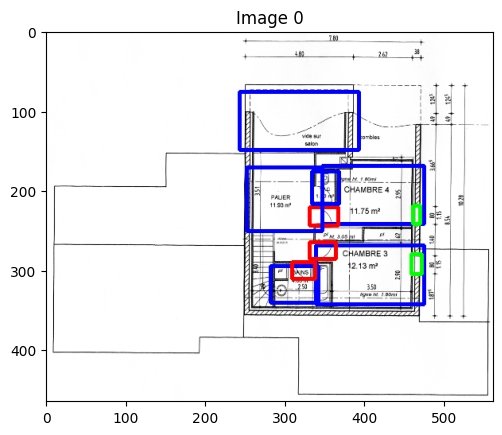

(433, 604, 3)


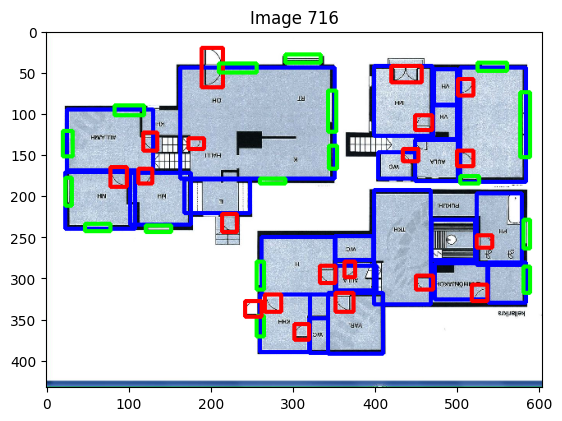

(691, 379, 3)


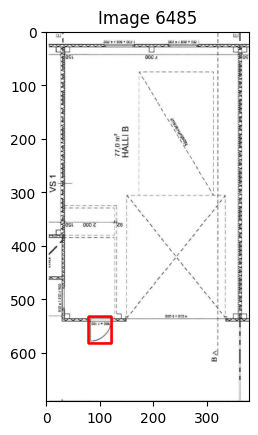

In [8]:
def get_data(img_id):
    
    label_path = os.path.join(LABEL_DIR, "%d.txt" %img_id)
    data = np.loadtxt(label_path)

    # When label file has only 1 line
    # np.loadtxt returns 1D array
    # reshape it into 2D array
    if len(data.shape) == 1:
        data = data.reshape((1, -1))
    
    img_path = os.path.join(IMG_DIR, "%d.png" % img_id)
    img = cv2.imread(img_path)

    height, width = img.shape[:2]

    target_size = 512 * 512

    ratio = np.sqrt(target_size * 1.0 / (height*width))

    new_height = int(height * ratio)
    new_width = int(width * ratio)
    
    img = cv2.resize(img, (new_width, new_height))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    labels = data[:, 0]
    labels = labels.astype(np.int8)
    
    boxes = data[:, 1:]

    boxes[:,0] -= boxes[:,2]/2
    boxes[:,1] -= boxes[:,3]/2
    boxes[:,2] += boxes[:,0]
    boxes[:,3] += boxes[:,1]

    # print(img.shape)
    # print(img)
    
    return img, labels, boxes

def scale_box(boxes, width, height):
    boxes[:,0] = boxes[:,0] * width
    boxes[:,1] = boxes[:,1] * height
    boxes[:,2] = boxes[:,2] * width
    boxes[:,3] = boxes[:,3] * height
    return boxes

def plot_data(img_id, img, labels, boxes):

    if np.max(boxes) < 1:
        height, width = img.shape[:2] 
        boxes = scale_box(boxes, width, height)
    
    boxes = np.round(boxes).astype(np.int32)
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    for label, box in zip(labels, boxes):
        cv2.rectangle(img,
                      (box[0], box[1]),
                      ( box[2], box[3]),
                      colors[label], 3)

    plt.imshow(img)
    plt.title("Image %d" %img_id)
    plt.show()
    

def plot_img(img_id):
    img, labels, boxes = get_data(img_id)
    print(img.shape)
    plot_data(img_id, img, labels, boxes)
    
plot_img(0)
plot_img(716)
plot_img(6485)

# Find Image IDs

In [9]:
png_files = [file for file in os.listdir(IMG_DIR) if file.endswith('.png')]
img_ids = [int(os.path.splitext(file)[0]) for file in png_files]
img_ids = sorted(img_ids)
img_ids[:10]

[0, 2, 3, 4, 7, 521, 522, 525, 526, 528]

# Split IDs into Train, Validation And Test Randomly

In [10]:
# img_ids = img_ids[:16]

random.seed(0)
random.shuffle(img_ids)
test_ratio = 0.2
total_samples = len(img_ids)
num_train = round(total_samples * (1-test_ratio))
train_ids = img_ids[:num_train]
test_ids = img_ids[num_train:]
num_val = len(test_ids) // 2
validation_ids = test_ids[:num_val]
test_ids = test_ids[num_val:]
print("total samples: %d" % len(img_ids))
print("train samples: %d" % len(train_ids))
print("validation samples: %d" % len(test_ids))
print("test samples: %d" % len(test_ids))

total samples: 2681
train samples: 2145
validation samples: 268
test samples: 268


# Implement PyTorch Dataset

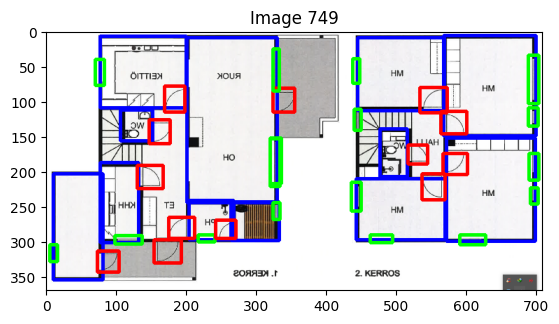

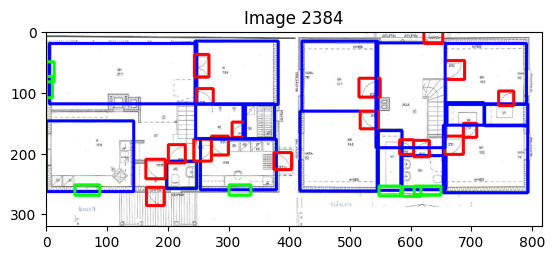

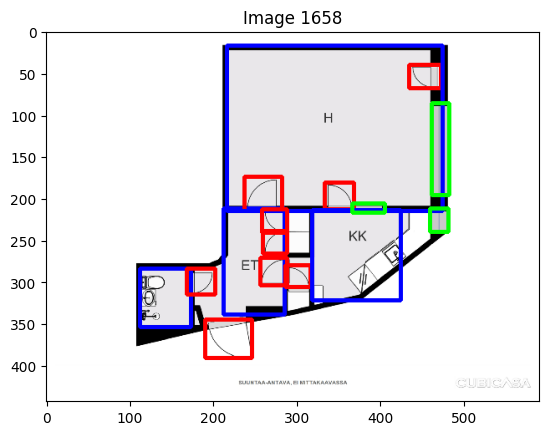

In [11]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((256, 256))
])

class FloorplanDataset(Dataset):

    def __init__(self, ids, transform=transform):
        super().__init__()
        self.ids = ids
        self.transform = transform

    def __len__(self) -> int:
        return len(self.ids)

    def __getitem__(self, i: int):
        
        img_id = self.ids[i]
        img, labels, boxes = get_data(img_id)
        img = img / 255.0
        
        if self.transform:
            img = self.transform(img)
            boxes = scale_box(boxes, width=img.shape[2], height = img.shape[1])

        img = torch.as_tensor(img, dtype=torch.float32)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels + 1, dtype=torch.int64)

        d = {"boxes": boxes, "labels":labels}
        
        return img_id, img, d


train_set = FloorplanDataset(train_ids)
validation_set = FloorplanDataset(validation_ids)
test_set = FloorplanDataset(test_ids)

def collate_fn(batch):
    return zip(*batch)

train_loader = DataLoader(
    train_set,
    batch_size=16,
    # num_workers=2,
    shuffle=False,
    collate_fn = collate_fn
)

validation_loader = DataLoader(
    validation_set,
    batch_size=16,
    # num_workers=2,
    shuffle=False,
    collate_fn = collate_fn
)

test_loader = DataLoader(
    test_set,
    batch_size=4,
    # num_workers=2,
    shuffle=False,
    collate_fn = collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Test by plot 3 images from training set
img_ids, imgs, ds = next(iter(train_loader))

count = 0
for img_id, img, d in zip(img_ids, imgs, ds):
    labels, boxes = d["labels"], d["boxes"]
    img = img.to(device).permute(1,2,0).cpu().numpy() * 255
    img = img.astype(np.uint8).copy()
    boxes = boxes.to(device).cpu().numpy().astype(np.uint32)
    plot_data(img_id, img, labels - 1, boxes)
    count+=1
    if count == 3:
        break



    

# Train Model

In [12]:
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

In [13]:
model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, num_classes=4)

In [14]:
model = model.to(device)


In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)


In [ ]:

def process_batch(imgs, ds):
    imgs = [img.to(device) for img in imgs]
    targets = list(ds)
    for t in targets:
        for k in t:
            t[k] = t[k].to(device)
    return imgs, targets
    
model.train()

def validate():
    losses = []

    for img_ids, imgs, ds in validation_loader:
        imgs, targets = process_batch(imgs, ds)
        with torch.no_grad():
            out = model(imgs, targets)
        
        loss = sum(out.values())
        losses.append(loss.item())

    return losses

def train(num_epochs, start = 0):
    
    train_losses = []
    val_losses = []
    for epoch in range(start, start + num_epochs):

        epoch_loss = []
       
        bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)
        for img_ids, imgs, ds in bar:
            imgs, targets = process_batch(imgs, ds)
    
            out = model(imgs, targets)
            loss = sum(out.values())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            epoch_loss.append(batch_loss)
            bar.set_description(desc=f"Epoch {epoch + 1}/{num_epochs} Loss: {batch_loss:.3f}")

        validation_loss = validate()

        checkpoint_path = f'checkpoint_epoch_{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'validation_loss': validation_loss
        }, checkpoint_path)
            
        lr_scheduler.step() 

        train_losses.append(epoch_loss)
        val_losses.append(validation_loss)

    return train_losses, val_losses
    
train_losses, val_losses = train(num_epochs = 5)

Epoch 1/5 Loss: 1.466:   9%|███████▋                                                                              | 12/135 [30:22<5:08:02, 150.26s/it]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: known incorrect sRGB profile
Epoch 1/5 Loss: 1.195:  14%|████████████                                                                          | 19/135 [47:47<4:53:40, 151.90s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Epoch 1/5 Loss: 1.032:  17%|██████████████▋                                                                       | 23/135 [57:43<4:39:56, 149.97s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Epoch 1/5 Loss: 1.065:  19%|███████████████▌                                                                    | 25/135 [1:02:48<4:37:30, 151.36s/it